In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from pathlib import Path
from src.__00__paths import test_dir, model_dir
from src.__02__model_creation import Genre_CNN, GenreSpectrogramDataset

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = Genre_CNN(num_classes=10).to(device)
model.load_state_dict(torch.load(model_dir / "genre_cnn_model.pth", map_location=device))
model.eval()
print("Model loaded.")

Model loaded.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_data = GenreSpectrogramDataset(test_dir, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
class_names = list(test_data.class_to_idx.keys())

In [5]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [9]:
import numpy as np
from sklearn.metrics import classification_report

# Compute overall accuracy
acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"✅ Test Accuracy: {acc:.4f}\n")

# Print classification report with zero_division fix
print("📊 Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0  # Prevents warning when a class is not predicted
))

✅ Test Accuracy: 0.2667

📊 Classification Report:

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        60
   classical       0.00      0.00      0.00        55
     country       0.00      0.00      0.00        54
       disco       0.15      0.67      0.24        57
      hiphop       0.41      0.87      0.56        53
        jazz       0.00      0.00      0.00        55
       metal       0.53      0.94      0.68        54
         pop       0.31      0.15      0.20        54
      reggae       0.00      0.00      0.00        56
        rock       0.08      0.09      0.08        57

    accuracy                           0.27       555
   macro avg       0.15      0.27      0.18       555
weighted avg       0.14      0.27      0.17       555



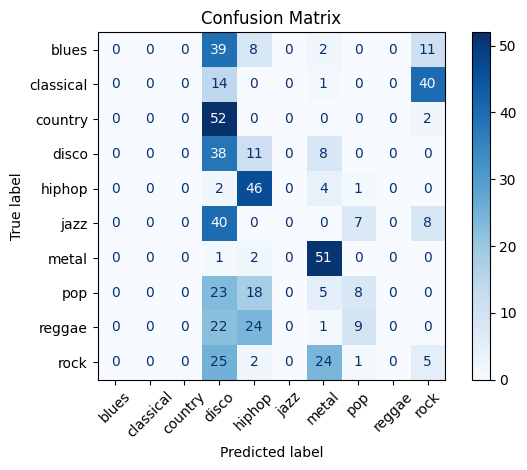

In [7]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

407 misclassified out of 555


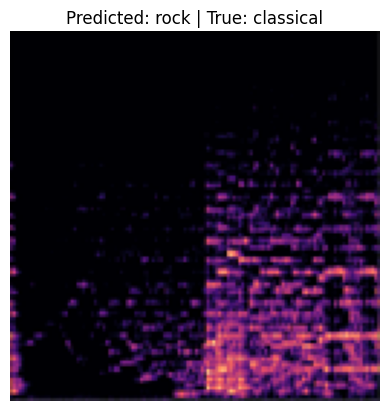

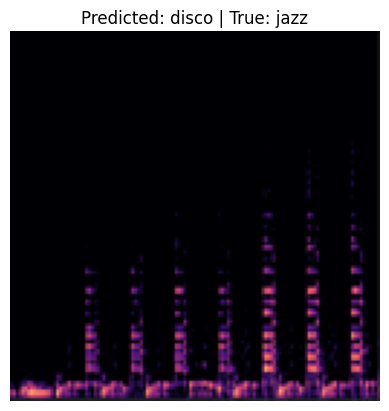

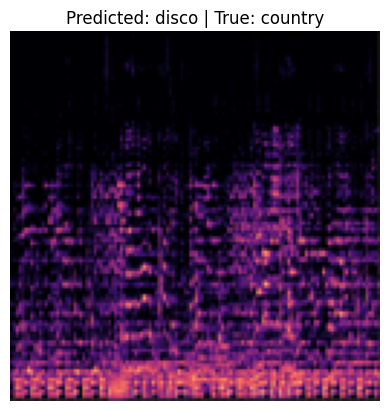

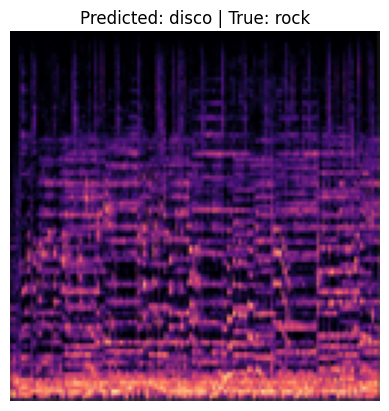

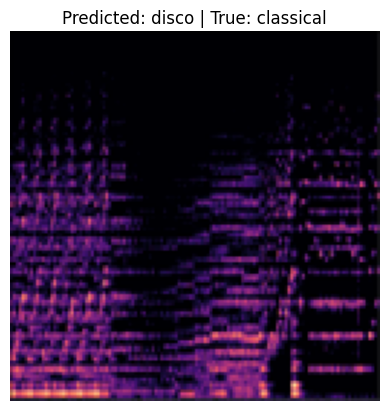

In [8]:
from random import sample

misclassified = [
    (i, pred, true) for i, (pred, true) in enumerate(zip(all_preds, all_labels)) if pred != true
]

print(f"{len(misclassified)} misclassified out of {len(test_data)}")

for idx, pred, true in sample(misclassified, k=min(5, len(misclassified))):
    img_path, _ = test_data.samples[idx]
    img = Image.open(img_path)

    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {class_names[pred]} | True: {class_names[true]}")
    plt.axis('off')
    plt.show()